In [1]:
from typing import Annotated
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from PIL import Image
from io import BytesIO
import random 
import gradio as gr

from langgraph.graph import StateGraph, START, END
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI 

In [2]:
nouns = ["Cabbages", "Unicorns", "Toasters", "Penguins", "Bananas", "Zombies", "Rainbows", "Eels", "Pickles", "Muffins"]
adjectives = ["outrageous", "smelly", "pedantic", "existential", "moody", "sparkly", "untrustworthy", "saracastic", "squishy", "haunted"]

In [3]:
load_dotenv(override=True)

True

Annotated gives a better description for type hinting (for other developers and better annotations especially for langgraph)

Langgraph needs to use this feature when we define state objects. This is due to telling it what funciton it should call to update the State with a new value (a reducer). The default reducer is add_messages (from the langgraph.graph.message library).

1. Define the State Object

In [4]:
class State(BaseModel):
    messages: Annotated[list, add_messages]

2. Start the Graph Builder (with initialise state class)

In [5]:
graph_builder = StateGraph(State)

3. Create a Node

Nodes (any python function). In this case the reducer that we set before gets automatically called to combine this response with previous responses. 

In [6]:
def first_node(previous_state: State) -> State:
    # node will respond with a response describling a noun. 
    reply = f"{random.choice(nouns)} are {random.choice(adjectives)}" 
    messages = [{"role": "assistant", "content": reply}]
    new_state = State(messages=messages)
    return new_state

In [7]:
graph_builder.add_node("first_node", first_node)

4. Create Edges

In [8]:
# START --> first_node --> END
graph_builder.add_edge(START, "first_node")
graph_builder.add_edge("first_node", END)

5. Compile the Graph

In [9]:
graph = graph_builder.compile()

In [10]:
# for visualisation purposes
display(graph.get_graph().draw_mermaid())

'---\nconfig:\n  flowchart:\n    curve: linear\n---\ngraph TD;\n\t__start__([<p>__start__</p>]):::first\n\tfirst_node(first_node)\n\t__end__([<p>__end__</p>]):::last\n\t__start__ --> first_node;\n\tfirst_node --> __end__;\n\tclassDef default fill:#f2f0ff,line-height:1.2\n\tclassDef first fill-opacity:0\n\tclassDef last fill:#bfb6fc\n'

Gradio Chat Function

In [11]:
def chat(user_input: str, history):
    message = {"role": "user", "content": user_input}
    messages = [message]
    state = State(messages=messages)
    result = graph.invoke(state)
    print(result)   
    return result["messages"][-1].content

In [12]:
gr.ChatInterface(chat, type='messages').launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## langgraph in llms

In [13]:
# create state object
class State(BaseModel):
    messages: Annotated[list, add_messages]

In [14]:
# step initalise graph builder with state class
graph_builder = StateGraph(State)

In [15]:
llm = ChatOpenAI(model="gpt-4o-mini")

# creating a new node per response
def chatbot_node(old_state: State) -> State: 
    response = llm.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatbot", chatbot_node)

In [16]:
# creating edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

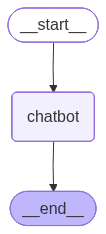

In [17]:
# compile the graph
graph = graph_builder.compile()
graph_visualisation = graph.get_graph().draw_mermaid_png()
graph_visualisation = Image.open(BytesIO(graph_visualisation))
graph_visualisation

In [18]:
def chat(user_input: str, history):
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    result = graph.invoke(initial_state)
    print(result)
    return result['messages'][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Choose a sentence based on the words I have provided', additional_kwargs={}, response_metadata={}, id='fe44c774-6edd-4a54-9183-7095d59b020c'), AIMessage(content='Of course! Please provide the words you would like me to use for the sentence.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 17, 'total_tokens': 34, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_c4585b5b9c', 'id': 'chatcmpl-D01X5ZaLsCnUoaVxhVLB1NBph9gLz', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--db0f89ec-4379-4d00-a684-de1a125ea0c3-0', usage_metadata={'input_tokens': 17, 'output_tokens': 17, 'total_tokens': 34, 'input_token_details': {'audio': 0, 'cache_read': 0}